# Importacao das bibliotecas

In [1]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import os
from datetime import datetime
import matplotlib.pyplot as plt
import sys
import math        #import needed modules
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import re
#import wave
from keras.models import load_model
from music21 import instrument, converter, note, chord, stream

Using TensorFlow backend.


# Setar variaveis

In [6]:
epochs = 30
stepsPerEpochs= 50
VALIDATION_SIZE = 1
BATCH_SIZE = 128
checkpoint ="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
seq_length = 4
bestmodel = 'bestModel.h5'

filename = "MusicTrain.txt"
filenameTest = "MusicTest.txt"


# Possiveis estilos musicais

In [7]:
querysMusicScale = pd.read_csv('QueryResult.csv')
escalaMusical = 'JapanesePentachord1'

In [8]:
querysMusicScale

,scale_name,root,column_c,column_d,column_e,column_f
0,Sus4Pentatonic,False,2,5,7,10.0
1,M3MjPentatonic,False,3,5,8,10.0
2,Chinese6Pentatonic,False,4,6,7,11.0
3,Han-kumoi,False,2,5,7,8.0
4,In,False,1,5,7,8.0
5,Yo,False,2,5,7,9.0
6,Indonesian2Pentatonic,False,1,6,7,8.0
7,BluesPentaCluster6,False,1,2,3,5.0
8,Blues#Vallflats,False,3,5,6,11.0
9,Center-ClusterPentaMirror,False,3,4,5,8.0


In [9]:

notas = pd.read_csv('notas.csv')
notas

,Número da tecla,Notação de Helmholtz,Notação científica (SPN),Frequência (Hz),Violino,Viola,Cello,Contrabaixo,Guitarra
0,108,b′′′′′,B8,"7902,133",NaN,NaN,NaN,NaN,NaN
1,107,a♯′′′′′/b♭′′′′′,A♯8/B♭8,"7458,620",NaN,NaN,NaN,NaN,NaN
2,106,a′′′′′,A8,"7040,000",NaN,NaN,NaN,NaN,NaN
3,105,g♯′′′′′/a♭′′′′′,G♯8/A♭8,"6644,875",NaN,NaN,NaN,NaN,NaN
4,104,g′′′′′,G8,"6271,927",NaN,NaN,NaN,NaN,NaN
5,103,f♯′′′′′/g♭′′′′′,F♯8/G♭8,"5919,911",NaN,NaN,NaN,NaN,NaN
6,102,f′′′′′,F8,"5587,652",NaN,NaN,NaN,NaN,NaN
7,101,e′′′′′,E8,"5274,041",NaN,NaN,NaN,NaN,NaN
8,100,d♯′′′′′/e♭′′′′′,D♯8/E♭8,"4978,032",NaN,NaN,NaN,NaN,NaN
9,99,d′′′′′,D8,"4698,636",NaN,NaN,NaN,NaN,NaN


# Processamento dos dados

In [10]:
def proccessedText(filetxt):
    raw_text = open(filetxt, 'r', encoding='utf-8').read()

    pattern = re.compile(r'([A-Z][♭♯]{0,1}[0-9])')
    processedText=''
    for m in re.finditer(pattern, raw_text):

        t = notas[notas['Notação científica (SPN)'].str.contains(m.group(1))]

        try:
            processedText += chr(t['Número da tecla'].values[0])
        except:
            print("err")
    return processedText

In [11]:
processedTrainText = "processedTrainText.txt"


f = open(processedTrainText, "w")
f.write(proccessedText(filename))
f.close()

processedTestText = "processedTestText.txt"


f = open(processedTestText, "w")
f.write(proccessedText(filenameTest))
f.close()

In [12]:

# create mapping of unique chars to integers
chars = [chr(n) for n in notas['Número da tecla'].unique().tolist()]

char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))
# summarize the loaded data
n_chars = len(notas['Número da tecla'].unique().tolist())
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  107
Total Vocab:  107


In [13]:
char_to_int

{'l': 0,
 'k': 1,
 'j': 2,
 'i': 3,
 'h': 4,
 'g': 5,
 'f': 6,
 'e': 7,
 'd': 8,
 'c': 9,
 'b': 10,
 'X': 11,
 'W': 12,
 'V': 13,
 'U': 14,
 'T': 15,
 'S': 16,
 'R': 17,
 'Q': 18,
 'P': 19,
 'O': 20,
 'N': 21,
 'M': 22,
 'L': 23,
 'K': 24,
 'J': 25,
 'I': 26,
 'H': 27,
 'G': 28,
 'F': 29,
 'E': 30,
 'D': 31,
 'C': 32,
 'B': 33,
 'A': 34,
 '@': 35,
 '?': 36,
 '>': 37,
 '=': 38,
 '<': 39,
 ';': 40,
 ':': 41,
 '9': 42,
 '8': 43,
 '7': 44,
 '6': 45,
 '5': 46,
 '4': 47,
 '3': 48,
 '2': 49,
 '1': 50,
 '0': 51,
 '/': 52,
 '.': 53,
 '-': 54,
 ',': 55,
 '+': 56,
 '*': 57,
 ')': 58,
 '(': 59,
 "'": 60,
 '&': 61,
 '%': 62,
 '$': 63,
 '#': 64,
 '"': 65,
 '!': 66,
 ' ': 67,
 '\x1f': 68,
 '\x1e': 69,
 '\x1d': 70,
 '\x1c': 71,
 '\x1b': 72,
 '\x1a': 73,
 '\x19': 74,
 '\x18': 75,
 '\x17': 76,
 '\x16': 77,
 '\x15': 78,
 '\x14': 79,
 '\x13': 80,
 '\x12': 81,
 '\x11': 82,
 '\x10': 83,
 '\x0f': 84,
 '\x0e': 85,
 '\r': 86,
 '\x0c': 87,
 '\x0b': 88,
 '\n': 89,
 '\t': 90,
 '\x08': 91,
 '\x07': 92,
 '\x06': 93

# Rede neural de 3 LSTMs

In [24]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(seq_length, 1), return_sequences=True))

model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(len(char_to_int), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])


In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 4, 256)            264192    
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 256)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 4, 256)            525312    
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 256)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 107)               27499     
Total para

In [26]:

if os.path.isfile(checkpoint):
    model.load_weights(checkpoint)

mc = ModelCheckpoint(checkpoint, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, min_delta=0.000001)
callbacks=[es, mc]

In [27]:

# Load data
def generate_arrays_from_file(path, batchsize):
    dataX = []
    dataY = []
    batchcount = 0
    while True:
        with open(path) as f:
            raw_text = f.read()
            
            for i in range(0, n_chars - seq_length, 1):
                seq_in = raw_text[i:i + seq_length]
                seq_out = raw_text[i + seq_length]
                dataX.append([char_to_int[char] for char in seq_in])
                dataY.append(char_to_int[seq_out])

                batchcount += 1

                if batchcount > batchsize:
                    X = numpy.reshape(dataX, (batchsize+1, seq_length, 1))
                    
                    onehot_encoded = list()

                    for data in dataY:
                        letter = [0 for _ in range(n_vocab)]
                        letter[data] = 1

                        onehot_encoded.append(letter)
                        
                    y = numpy.array(onehot_encoded)
                        
                    #print(len(y[0]),y[0])
                    yield (X, y)                    
                    dataX = []
                    dataY = []
                    batchcount = 0
             

In [28]:
history = model.fit_generator( generate_arrays_from_file(processedTrainText,BATCH_SIZE), epochs=epochs, steps_per_epoch=stepsPerEpochs, verbose=1, validation_data=generate_arrays_from_file(processedTestText,BATCH_SIZE),callbacks = callbacks, validation_steps=10)

Epoch 1/30
50/50 [==============================] - 6s 125ms/step - loss: 2.0445 - acc: 0.2893 - val_loss: 4.5646 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 4.56462, saving model to weights-improvement-01-2.0445-bigger.hdf5
Epoch 2/30
50/50 [==============================] - 2s 46ms/step - loss: 1.7096 - acc: 0.3136 - val_loss: 4.5736 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve from 4.56462
Epoch 3/30
50/50 [==============================] - 2s 45ms/step - loss: 1.7023 - acc: 0.3191 - val_loss: 4.6254 - val_acc: 0.0000e+00

Epoch 00003: val_loss did not improve from 4.56462
Epoch 4/30
50/50 [==============================] - 2s 45ms/step - loss: 1.6874 - acc: 0.3189 - val_loss: 4.7872 - val_acc: 0.0000e+00

Epoch 00004: val_loss did not improve from 4.56462
Epoch 5/30
50/50 [==============================] - 2s 45ms/step - loss: 1.6455 - acc: 0.3236 - val_loss: 4.9350 - val_acc: 0.1070

Epoch 00005: val_loss did not improve from 4.56462
Epoch 6/3

# Salvar modelo

In [ ]:
model.save(bestmodel)
print("Saved model to disk")

In [29]:
history.history

{'val_loss': [4.56462025642395,
  4.573609828948975,
  4.6254278182983395,
  4.7871500015258786,
  4.935040855407715,
  4.879218673706054,
  5.0095494270324705,
  5.126228904724121,
  5.269150638580323,
  5.485407018661499,
  6.0389868259429935,
  6.656508255004883,
  6.59749550819397,
  6.760547018051147,
  7.123628091812134,
  7.336568832397461,
  7.545628499984741,
  8.480338764190673,
  8.29301700592041,
  8.91579008102417,
  8.805681228637695,
  8.842973136901856,
  9.3608154296875,
  9.595769786834717,
  8.229618263244628,
  8.94973382949829,
  9.235875988006592,
  9.482919502258301,
  8.788277721405029,
  10.01958122253418],
 'val_acc': [0.0,
  0.0,
  0.0,
  0.0,
  0.1069767452776432,
  0.10697674602270127,
  0.07751937955617905,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.028682170435786247,
  0.0,
  0.0,
  0.0,
  0.029457364231348038,
  0.028682170435786247,
  0.029457364231348038,
  0.028682170435786247,
  0.029457364231348038,
  0.0488372091203928,
  0.04806201532483101,
 

# Informacoes de acuracia

<module 'matplotlib.pyplot' from 'c:\\users\\t-gamer\\documents\\git\\projetointeligenciaartificialsistemasugestao\\gpuvenv\\lib\\site-packages\\matplotlib\\pyplot.py'>

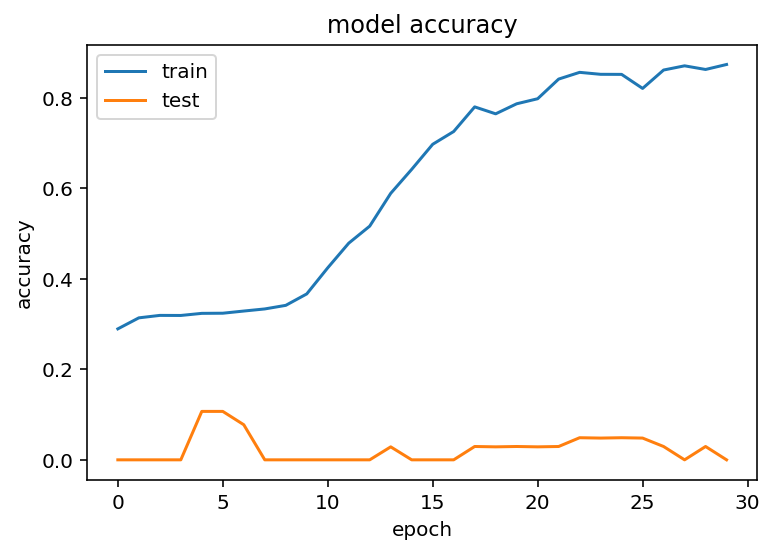

In [30]:
time = datetime.now()
timestampStr = time.strftime("%d %b %Y %H %M %S %f)")
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt

<module 'matplotlib.pyplot' from 'c:\\users\\t-gamer\\documents\\git\\projetointeligenciaartificialsistemasugestao\\gpuvenv\\lib\\site-packages\\matplotlib\\pyplot.py'>

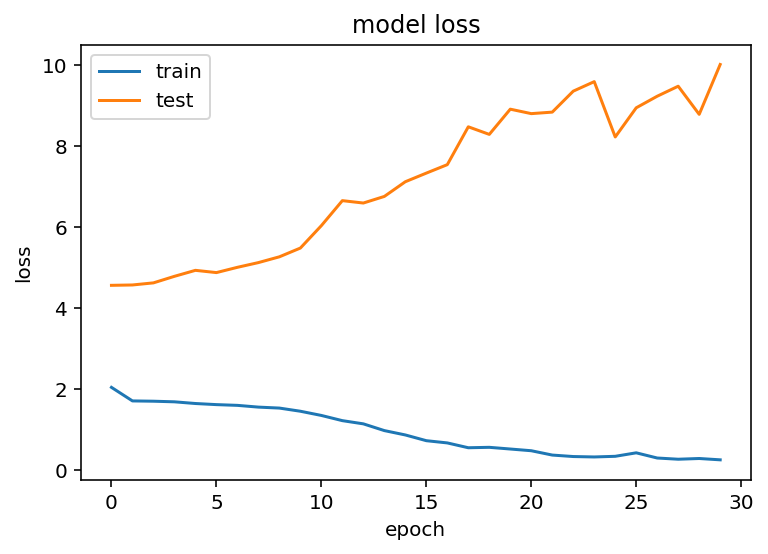

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("loss"+timestampStr+".png")
plt

# PREDICAO

In [34]:
#model = load_model(bestmodel)
model = load_model('weights/weights-improvement-01-1.3232-bigger.hdf5')

In [113]:
linha = ''
for ind, ob in enumerate(querysMusicScale.loc[(querysMusicScale['scale_name'] == escalaMusical)].values.tolist()[0]):
    if ind>1:
        linha = linha + int_to_char[ob]

In [114]:
'''
testText = open('predict.txt', 'r', encoding='utf-8').read()

dataTestX = []
seq_in = testText[0: seq_length]

dataTestX.append([char_to_int[char] for char in seq_in])
'''
dataTestX = []
seq_in = linha
dataTestX.append([char_to_int[char] for char in linha])



In [115]:
dataTestX

[[1, 3, 6, 7]]

In [116]:
dataTestX

[[1, 3, 6, 7]]

In [117]:

seq_in = seq_in
print(seq_in)

kife


In [118]:
testX = numpy.reshape(dataTestX, (1, seq_length, 1))

prediction = model.predict(testX, verbose=0)
index = numpy.argmax(prediction)
print(int_to_char[index])

+


In [119]:
resultado = ""
for i in range(100):
    testX = numpy.reshape(dataTestX, (1, seq_length, 1))

    prediction = model.predict(testX, verbose=0)
    index = numpy.argmax(prediction)
    
    resultado += int_to_char[index]
    
    dataTestX[0].pop(0) 
    dataTestX[0].append(index)



In [120]:
resultado
                        

'+++*(*+--++++(**++****++****++****++****++****++****++****++****++****++****++****++****++****++****'

In [121]:
print(seq_in + resultado)

kife+++*(*+--++++(**++****++****++****++****++****++****++****++****++****++****++****++****++****++****


In [122]:
musica = ""
prediction_output=[]
for char in resultado:
    prediction_output.append(notas.loc[notas['Número da tecla'] == ord(char)]['Notação científica (SPN)'].values[0])
    
    musica += prediction_output[-1]+"-"
print(musica)    

D♯4/E♭4-D♯4/E♭4-D♯4/E♭4-D4-C4-D4-D♯4/E♭4-F4-F4-D♯4/E♭4-D♯4/E♭4-D♯4/E♭4-D♯4/E♭4-C4-D4-D4-D♯4/E♭4-D♯4/E♭4-D4-D4-D4-D4-D♯4/E♭4-D♯4/E♭4-D4-D4-D4-D4-D♯4/E♭4-D♯4/E♭4-D4-D4-D4-D4-D♯4/E♭4-D♯4/E♭4-D4-D4-D4-D4-D♯4/E♭4-D♯4/E♭4-D4-D4-D4-D4-D♯4/E♭4-D♯4/E♭4-D4-D4-D4-D4-D♯4/E♭4-D♯4/E♭4-D4-D4-D4-D4-D♯4/E♭4-D♯4/E♭4-D4-D4-D4-D4-D♯4/E♭4-D♯4/E♭4-D4-D4-D4-D4-D♯4/E♭4-D♯4/E♭4-D4-D4-D4-D4-D♯4/E♭4-D♯4/E♭4-D4-D4-D4-D4-D♯4/E♭4-D♯4/E♭4-D4-D4-D4-D4-D♯4/E♭4-D♯4/E♭4-D4-D4-D4-D4-D♯4/E♭4-D♯4/E♭4-D4-D4-D4-D4-


# Tocar a musica

In [123]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music'+escalaMusical+'.mid')

In [124]:
for element in prediction_output:
    element = element.replace("♯","#")

for i in range(0, len(prediction_output), 1):
    prediction_output[i] = prediction_output[i].replace("♯","#")
    if(len(prediction_output[i])>2):
        prediction_output[i] = prediction_output[i][:3]

In [125]:
convert_to_midi(prediction_output)